# <u>Diagnosis of Diabetes using weight adjusted voting of an ensemble of classifiers<u>


## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
#from sklearn.neural_network import MLPClassifier #--- only available in sklearn 0.18
from sklearn import svm
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

## Loading the data

In [2]:
dataFrame = pd.read_table('pima-indians-diabetes.data', sep =',', header = None)

In [3]:
#dataFrame.shape
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
0    768 non-null int64
1    768 non-null int64
2    768 non-null int64
3    768 non-null int64
4    768 non-null int64
5    768 non-null float64
6    768 non-null float64
7    768 non-null int64
8    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


In [4]:
dataFrame.columns = ['no_times_pregnant','plasma_glucose_conc','diastolic_bp',\
                    'triceps_sf_thickness','insulin','bmi',\
                     'diabetes_pedigree_function','age','isDiabetic']
#dataFrame['no_times_pregnant_squared'] = dataFrame['no_times_pregnant']*dataFrame['no_times_pregnant']

## Exploring the data

In [5]:
dataFrame.head()


,no_times_pregnant,plasma_glucose_conc,diastolic_bp,triceps_sf_thickness,insulin,bmi,diabetes_pedigree_function,age,isDiabetic
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
dataFrame.describe()

,no_times_pregnant,plasma_glucose_conc,diastolic_bp,triceps_sf_thickness,insulin,bmi,diabetes_pedigree_function,age,isDiabetic
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
# Test and make sure that this function runs even without an internet connection
pandas_profiling.ProfileReport(dataFrame)

Number of variables,9
Number of observations,768
Total Missing (%),0.0%
Total size in memory,60.0 KiB
Average record size in memory,80.0 B
Numeric,9
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,52


In [7]:
dataFrame.groupby('isDiabetic').mean()

,no_times_pregnant,plasma_glucose_conc,diastolic_bp,triceps_sf_thickness,insulin,bmi,diabetes_pedigree_function,age
isDiabetic,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [8]:
# This command makes the notebook as the canvas and displays the plots in the notebook
%matplotlib inline 

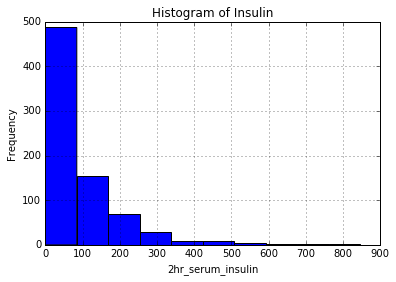

In [9]:
dataFrame.insulin.hist()
plt.title('Histogram of Insulin')
plt.xlabel('2hr_serum_insulin')
plt.ylabel('Frequency')

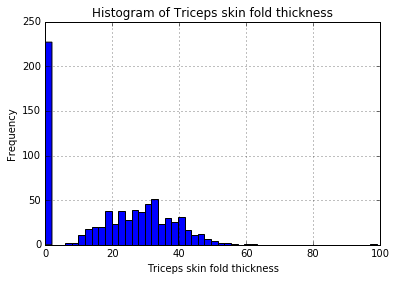

In [10]:
dataFrame.triceps_sf_thickness.hist(bins = 50)
plt.title('Histogram of Triceps skin fold thickness')
plt.xlabel('Triceps skin fold thickness')
plt.ylabel('Frequency')

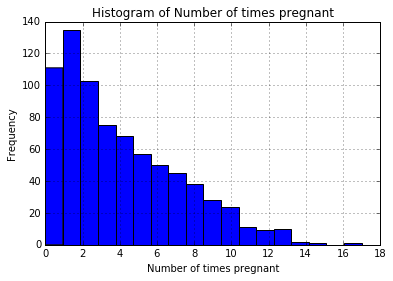

In [11]:
dataFrame.no_times_pregnant.hist(bins = 18)
plt.title('Histogram of Number of times pregnant')
plt.xlabel('Number of times pregnant')
plt.ylabel('Frequency')

### <u>From the above plot we cannot conclude that the Number of times pregnant column has missing values<u>, since there maybe patients who have not been pregnant even once.
## The summary of all the cloumns with missing values is as follows
   1. ~~Number of times pregnant = 111~~
   2. Plasma glucose concentration = 5
   3. Diastolic blood pressure = 35
   4. Triceps skin fold thickness = 227
   5. 2-Hour serum insulin = 374
   6. Body mass index = 11
   7. Diabetes pedigree function = NONE
   8. Age (years) = NONE
    

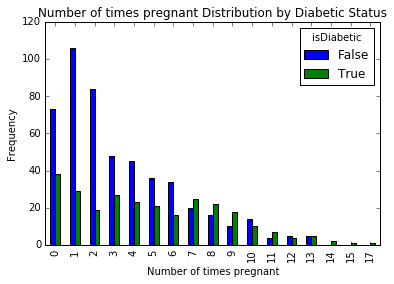

In [12]:
pd.crosstab(dataFrame.no_times_pregnant, dataFrame.isDiabetic.astype(bool)).plot(kind='bar')
plt.title('Number of times pregnant Distribution by Diabetic Status')
plt.xlabel('Number of times pregnant')
plt.ylabel('Frequency')

## <u>Preparing the data<u>


In [13]:
# removing the rows from the data set where some values are 0's that do not biologically make sense
dataFrame = dataFrame[dataFrame['diastolic_bp'] !=0]
dataFrame = dataFrame[dataFrame['bmi'] !=0]


diabetic_patients = dataFrame[dataFrame['isDiabetic']==1]
non_diabetic_patients = dataFrame[dataFrame['isDiabetic']==0]


dp1,dp2,dp3 = np.array_split(diabetic_patients,3)
ndp1,ndp2,ndp3 = np.array_split(non_diabetic_patients,3)

frames1 = [dp1,ndp1]
frames2 = [dp2,ndp2]
frames3 = [dp3,ndp3]

dataset1 = pd.concat(frames1)
dataset2 = pd.concat(frames2)
dataset3 = pd.concat(frames3)

#print(dataFrame.loc[245:253])
print(diabetic_patients.shape)
print(non_diabetic_patients.shape)
print(dataset1.shape)
print(dataset2.shape)
print(dataset3.shape)

(251, 9)
(478, 9)
(244, 9)
(243, 9)
(242, 9)


#### Split the data set into training set and test set

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#features = ['no_times_pregnant_squared','plasma_glucose_conc','diastolic_bp',\
                   # 'triceps_sf_thickness','insulin','bmi',\
                    # 'diabetes_pedigree_function','age']
features = ['no_times_pregnant','plasma_glucose_conc','diastolic_bp',\
                    'triceps_sf_thickness','insulin','bmi',\
                     'diabetes_pedigree_function','age']
output = ['isDiabetic']

X_train = dataset1[features]
y_train = dataset1[output]

X_test = dataset2[features]
y_test = dataset2[output]

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#######################################
#X_last = dataset3[features]
#y_last = dataset3[output]
#########################################

(244, 8)
(243, 8)
(244,)
(243,)


### <u>Sensitivity (aka hit-rate or recall)<u> 
   #### TPR =  TP/P   ==>   TP/TP+FN

### <u>Specificity<u> 
   #### TNR = TN/N ==>   TN/FP+TN 
   
### <u>Confusion  <u>  


In [58]:
def get_my_metrics(predicted, actual):
    CF_matrix = metrics.confusion_matrix(predicted, actual)
    sensitivity = CF_matrix[0,0]/(CF_matrix[0,0] + CF_matrix[1,0])
    specificity = CF_matrix[1,1]/(CF_matrix[0,1] + CF_matrix[1,1])
    #print("Confusion Matrix")
    #print(CF_matrix)
    print("\n")
    print("Sensitivity = ",sensitivity *100,"%")
    print("Specificity = ",specificity *100,"%")

## <u>Logistic Regression<u>

In [16]:
#dataFrame['constant'] = 1
#dataFrame = ['constant'] + dataFrame

LR_model = LogisticRegression(fit_intercept = True, C=3.0)
LR_model.fit(X_train, y_train)

LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
#LR_model.score(X,y) 

LR_predictions = LR_model.predict(X_test)
print ("Accuracy = ",metrics.accuracy_score(y_test, LR_predictions)*100,'%') #prints the accuracy on the test set

Accuracy =  74.4855967078 %


In [18]:
get_my_metrics(y_test, LR_predictions)
print("\n")
print("Classification report")
print (metrics.classification_report(y_test, LR_predictions))

Confusion Matrix
[[142  17]
 [ 45  39]]


Sensitivity =  75.935828877 %
Specificity =  69.6428571429 %


Classification report
             precision    recall  f1-score   support

          0       0.76      0.89      0.82       159
          1       0.70      0.46      0.56        84

avg / total       0.74      0.74      0.73       243



#### Evaluate the model Using cross-validation

In [19]:
# cv = 10 indicates 10 fold cross validation
LR_cv_scores = cross_val_score(LogisticRegression(), X_train, y_train, scoring = 'accuracy', cv = 10)

print(LR_cv_scores *100, '%')
print(LR_cv_scores.mean()*100,'%')

[ 68.          44.          80.          72.          83.33333333
  83.33333333  75.          83.33333333  58.33333333  58.33333333] %
70.5666666667 %


## <U>Support Vector Machines<U>
 #### Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale the data. 
 ##### -  scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1.

In [20]:
#SVM_X_train, SVM_X_test, SVM_y_train, SVM_y_test = train_test_split(X, y, test_size=0.3, random_state=0)
SVM_X_train = X_train
SVM_X_test = X_test
SVM_y_train = y_train
SVM_y_test = y_test

featureScaler = MinMaxScaler(feature_range=(0,1))
featureScaler.fit(SVM_X_train)
SVM_X_train = featureScaler.transform(SVM_X_train)
SVM_X_test = featureScaler.transform(SVM_X_test)

In [21]:
SVM_model = svm.SVC(kernel='rbf', C = 3.0)  #class_weight= 'balanced')
SVM_model.fit(SVM_X_train, SVM_y_train)


SVC(C=3.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
SVM_predictions = SVM_model.predict(SVM_X_test)
#SVM_model.score(SVM_X_test, SVM_y_test)

print ("Accuracy = ",metrics.accuracy_score(SVM_y_test, SVM_predictions) *100 ,'%')

Accuracy =  74.8971193416 %


In [23]:
get_my_metrics(SVM_y_test, SVM_predictions)
print("\n")
print("Classification Report")
print (metrics.classification_report(SVM_y_test, SVM_predictions))

Confusion Matrix
[[144  15]
 [ 46  38]]


Sensitivity =  75.7894736842 %
Specificity =  71.6981132075 %


Classification Report
             precision    recall  f1-score   support

          0       0.76      0.91      0.83       159
          1       0.72      0.45      0.55        84

avg / total       0.74      0.75      0.73       243



#### Evaluate the model using cross validation

In [24]:
svm_cv_scores = cross_val_score(svm.SVC(), SVM_X_train, SVM_y_train, scoring = 'accuracy', cv = 10)

print(svm_cv_scores *100, '%')
print(svm_cv_scores.mean()*100,'%')

[ 56.          68.          68.          64.          66.66666667  75.
  70.83333333  70.83333333  62.5         66.66666667] %
66.85 %


## <u>Naive Bayes<u> 

In [25]:
#NB_X_train, NB_X_test, NB_y_train, NB_y_test = train_test_split(X, y, test_size=0.3, random_state=0)

NB_X_train = X_train
NB_X_test = X_test
NB_y_train = y_train
NB_y_test = y_test

featureScaler = MinMaxScaler(feature_range=(0,1))
featureScaler.fit(NB_X_train)
NB_X_train = featureScaler.transform(NB_X_train)
NB_X_test = featureScaler.transform(NB_X_test)

In [26]:
NB_model = GaussianNB()
NB_model.fit(NB_X_train, NB_y_train)

GaussianNB()

In [27]:
NB_predictions = NB_model.predict(NB_X_test)
print ("Accuracy = ",metrics.accuracy_score(NB_y_test, NB_predictions) *100 ,'%')

Accuracy =  69.5473251029 %


In [28]:
get_my_metrics(NB_y_test, NB_predictions)
print("\n")
print("Classification Report")
print (metrics.classification_report(NB_y_test, NB_predictions))

Confusion Matrix
[[124  35]
 [ 39  45]]


Sensitivity =  76.0736196319 %
Specificity =  56.25 %


Classification Report
             precision    recall  f1-score   support

          0       0.76      0.78      0.77       159
          1       0.56      0.54      0.55        84

avg / total       0.69      0.70      0.69       243



## <u> Random Forests<u>

In [29]:
RF_X_train = X_train
RF_X_test = X_test
RF_y_train = y_train
RF_y_test = y_test

featureScaler = MinMaxScaler(feature_range=(0,1))
featureScaler.fit(RF_X_train)
RF_X_train = featureScaler.transform(RF_X_train)
RF_X_test = featureScaler.transform(RF_X_test)

In [30]:
RF_model = RandomForestClassifier(n_estimators=150, max_depth=2, random_state=1)
RF_model.fit(RF_X_train, RF_y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [31]:
RF_predictions_forTrainSet = RF_model.predict(RF_X_train)
RF_predictions_forTestSet = RF_model.predict(RF_X_test)
print ("Train Accuracy = ",metrics.accuracy_score(RF_y_train, RF_predictions_forTrainSet) *100 ,'%')
print ("Test Accuracy = ",metrics.accuracy_score(RF_y_test, RF_predictions_forTestSet) *100 ,'%')

Train Accuracy =  78.2786885246 %
Test Accuracy =  75.3086419753 %


In [32]:
get_my_metrics(RF_y_test, RF_predictions_forTestSet)
print("\n")
print("Classification Report")
print (metrics.classification_report(RF_y_test, RF_predictions_forTestSet))

Confusion Matrix
[[152   7]
 [ 53  31]]


Sensitivity =  74.1463414634 %
Specificity =  81.5789473684 %


Classification Report
             precision    recall  f1-score   support

          0       0.74      0.96      0.84       159
          1       0.82      0.37      0.51        84

avg / total       0.77      0.75      0.72       243



### <u> K- nearest Neighbours<u>


In [33]:
KNN_X_train = X_train
KNN_X_test = X_test
KNN_y_train = y_train
KNN_y_test = y_test

featureScaler = MinMaxScaler(feature_range=(0,1))
featureScaler.fit(KNN_X_train)
RF_X_train = featureScaler.transform(KNN_X_train)
RF_X_test = featureScaler.transform(KNN_X_test)

In [34]:
KNN_model = KNeighborsClassifier(n_neighbors=3)
#KNN_model = RadiusNeighborsClassifier(radius=1.0)
KNN_model.fit(KNN_X_train, KNN_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [35]:
KNN_predictions_forTrainSet = KNN_model.predict(KNN_X_train)
KNN_predictions_forTestSet = KNN_model.predict(KNN_X_test)
print ("Train Accuracy = ",metrics.accuracy_score(KNN_y_train, KNN_predictions_forTrainSet) *100 ,'%')
print ("Test Accuracy = ",metrics.accuracy_score(KNN_y_test, KNN_predictions_forTestSet) *100 ,'%')

Train Accuracy =  78.2786885246 %
Test Accuracy =  72.8395061728 %


In [36]:
get_my_metrics(KNN_y_test, KNN_predictions_forTestSet)
print("\n")
print("Classification Report")
print (metrics.classification_report(KNN_y_test, KNN_predictions_forTestSet))

Confusion Matrix
[[130  29]
 [ 37  47]]


Sensitivity =  77.8443113772 %
Specificity =  61.8421052632 %


Classification Report
             precision    recall  f1-score   support

          0       0.78      0.82      0.80       159
          1       0.62      0.56      0.59        84

avg / total       0.72      0.73      0.72       243



### <u> Ada Boost <u>

In [37]:
ADA_X_train = X_train
ADA_X_test = X_test
ADA_y_train = y_train
ADA_y_test = y_test

featureScaler = MinMaxScaler(feature_range=(0,1))
featureScaler.fit(ADA_X_train)
ADA_X_train = featureScaler.transform(ADA_X_train)
ADA_X_test = featureScaler.transform(ADA_X_test)

In [38]:
ADA_model = AdaBoostClassifier(n_estimators=100)
ADA_model.fit(ADA_X_train, ADA_y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [39]:
ADA_predictions_forTrainSet = ADA_model.predict(ADA_X_train)
ADA_predictions_forTestSet = ADA_model.predict(ADA_X_test)
print ("Train Accuracy = ",metrics.accuracy_score(ADA_y_train, ADA_predictions_forTrainSet) *100 ,'%')
print ("Test Accuracy = ",metrics.accuracy_score(ADA_y_test, ADA_predictions_forTestSet) *100 ,'%')

Train Accuracy =  96.3114754098 %
Test Accuracy =  71.6049382716 %


In [40]:
get_my_metrics(ADA_y_test, ADA_predictions_forTestSet)
print("\n")
print("Classification Report")
print (metrics.classification_report(ADA_y_test, ADA_predictions_forTestSet))

Confusion Matrix
[[130  29]
 [ 40  44]]


Sensitivity =  76.4705882353 %
Specificity =  60.2739726027 %


Classification Report
             precision    recall  f1-score   support

          0       0.76      0.82      0.79       159
          1       0.60      0.52      0.56        84

avg / total       0.71      0.72      0.71       243



## <u>Multidimensional Scaling<u>
### Visualizing the data 
#### - reducing the number of features from 8 to 2, so that it can be plotted in a 2D graph

In [41]:
#mds = MDS(n_components=2, dissimilarity='precomputed')

#similarities = euclidean_distances(X.astype(np.float64))
#print (similarities.shape)

#pos = mds.fit_transform(similarities.astype(np.float64))
#print(pos.shape)

In [42]:
#plt.scatter(pos[:, 0], pos[:, 1], c=y, cmap=plt.cm.Paired)
#plt.xlabel('Coordinates 1')
#plt.ylabel('Coordinates 2')
#plt.title("Pima Indian diabetes dataset")

# <u> Weight Adjusting <u>

In [43]:
# TODO : create a class for the adjust_weights and voting algorithms called "WeightAdjustedVoting"

def adjust_weights(all_predictions_matrix, actual_values, step_size1, step_size2):
    # Note: the rows in the predictions matrix are the different models and columns are the samples
    n_models, n_samples = all_predictions_matrix.shape
    actual_values = actual_values.T #Transpose the matrix to match the dimensions of predictions_matrix
    n_actual_values = actual_values.shape
    
    
    #if(n_samples != n_actual_values):
       # print("The size of model predictions is not the same as the size of actual values")
        #return
    
    import math
    majority = int(math.ceil(n_models/2))
    
    # Creating an array of weights for all the models and filling them with initial weights
    initial_weights = 1/n_models
    weights_of_models = np.empty(n_models)
    weights_of_models.fill(initial_weights)
    
     # In case of n_models = 1 or 2 do not change the weights 
    if(n_models == 1 or n_models == 2):
        return weights_of_models
        
    
    # Comparing the predictions of each model with the actual values and hence creating a matrix of 0's and 1's
    for i in range(0,n_models):
        all_predictions_matrix[i,:] = np.array([all_predictions_matrix[i,:] == actual_values])


    # Adjusting the Weights
    for j in  range(0, n_samples):
        sum = np.sum(all_predictions_matrix[:,j])  
        # if all the models predicted correct or if all models predicted wrong then return without changing the weights
        if(sum == 0 or sum == n_models):
            continue
        
        # If the no.of models that predicted correct and wrong are euqal then do not change the weights
        #if(n_models%2 == 0 and sum == n_models/2):
            #continue        
        
        correct_models, wrong_models = get_correct_and_wrong_models(all_predictions_matrix[:,j])
       
        if(sum >= majority):
            for a in correct_models: # Note: 'a' here is the value in the list 'correct_models'
                weights_of_models[a] += step_size1/(len(correct_models)/len(wrong_models))              
            
            for b in wrong_models:
                weights_of_models[b] -= step_size1 
       
        else:
            for s in correct_models:
                weights_of_models[s] += (len(wrong_models)/len(correct_models))*step_size2
             
            for e in wrong_models:
                weights_of_models[e] -= step_size2 
        
    return weights_of_models


# testing for the above function
h = np.array([[1,1],[1,1],[1,1]])
k = np.array([1,0]) 
#print(np.sum(h[:,0]))

weights_test = adjust_weights(h, k, 0.3, 0.1)
print(weights_test)

[ 0.33333333  0.33333333  0.33333333]


In [44]:
def get_correct_and_wrong_models(list):
    correct_classifier = []
    wrong_classifier = []
    for i in range(0, len(list)):
        if(list[i] == 1):
            correct_classifier.append(i)
        elif(list[i]==0):
            wrong_classifier.append(i)
    return(correct_classifier, wrong_classifier)

# testing for the above function
c, w = get_correct_and_wrong_models([1,0,1])
print(c)
print(w)

[0, 2]
[1]


In [45]:
#list = np.array([LR_predictions[i], SVM_predictions[i], NB_predictions[i], 
                        #RF_predictions_forTestSet[i], KNN_predictions_forTestSet[i], ADA_predictions_forTestSet[i]])
def voting(list, weights):
    if(np.sum(list)== 0):
        return 0
    
    import math
    majority = int(math.ceil(len(list)/2))
    if(np.sum(list) > majority):
         return 1
    # If the no.of models that predict possitive and negative are equal then predict as positive
    #if(len(list)%2 == 0 and np.sum(list) >= majority):
        #return 1
    
    else:
        correct_models, wrong_models = get_correct_and_wrong_models(list)
        
        weight_of_positive_models = 0
        weight_of_negative_models = 0
        
        for a in correct_models:
            weight_of_positive_models += weights[a]
            
        for b in wrong_models:
            weight_of_negative_models += weights[b]
        
        weight_of_positive_models = weight_of_positive_models/len(correct_models)
        
        #weight_of_negative_models = float(weight_of_negative_models/len(wrong_models))
        weight_of_negative_models = weight_of_negative_models/len(wrong_models)
        
        #print("Positive weight = ", weight_of_positive_models)
        #print("Negative weight = ", weight_of_negative_models)
        if(weight_of_positive_models > weight_of_negative_models):
            return 1
        else:
            return 0
         
# testing for the above function
list_test = [1,0,0,0,0]
weights_test = [0.3,0.3,0.3,0.3,0.3]
print(voting(list_test,weights_test))

0


In [108]:
all_predictions = np.array([LR_predictions, SVM_predictions, NB_predictions, 
                            RF_predictions_forTestSet, KNN_predictions_forTestSet, ADA_predictions_forTestSet])

all_predictions = all_predictions[:3,:]
print(all_predictions.shape)


shape = y_test.shape
nInstances = shape[0]
step_size1 = 0.01
step_size2 = 0.01
    
#Note: REMEMBER, the 'all_predictions matrix' get changed in the Weight adjusting function. Hence create a new variable
#Its really important to create a new memory (np.array()), if not both the variables point to same object.
all_predictions_for_votingFunction = np.array(all_predictions)

weights = adjust_weights(all_predictions, y_test, step_size1, step_size2)

print(weights)

(3, 243)
[ 0.35833333  0.37333333  0.26833333]


In [109]:
# currently using dataset 2 for phase 3: voting    
# later change it to use dataset 3
shape = y_test.shape
nInstances = shape[0]
print(nInstances)

final_result = np.empty(nInstances)
for i in  range(0, nInstances):
    final_result[i] = voting(all_predictions_for_votingFunction[:,i], weights)

    
print ("Final Accuracy = ",metrics.accuracy_score(y_test, final_result) *100 ,'%')

get_my_metrics(y_test, final_result)
print("\n")
print("Classification Report")
print (metrics.classification_report(y_test, final_result))

f_score = f1_score(y_test, final_result, average= None)
f_score = (f_score[0] + f_score[1])/2
print(f1_score(y_test, final_result, average= None))
print(f_score)

243
Final Accuracy =  74.4855967078 %


Sensitivity =  75.3926701571 %
Specificity =  71.1538461538 %


Classification Report
             precision    recall  f1-score   support

          0       0.75      0.91      0.82       159
          1       0.71      0.44      0.54        84

avg / total       0.74      0.74      0.73       243

[ 0.82285714  0.54411765]
0.683487394958


In [110]:
def get_my_metrics2(predicted, actual):
    CF_matrix = metrics.confusion_matrix(predicted, actual)
    sensitivity = CF_matrix[0,0]/(CF_matrix[0,0] + CF_matrix[1,0])
    specificity = CF_matrix[1,1]/(CF_matrix[0,1] + CF_matrix[1,1])
    return sensitivity, specificity

In [103]:
def find_best_stepSizeValue():
    shape = y_test.shape
    nInstances = shape[0]

    range_of_step_values = np.arange(0.01,0.9,0.01)
    
    final_result = np.empty(nInstances)
    
    import csv
    with open('6classifiers.csv', 'w') as csvfile:
        fieldnames = ['Step size 1', 'Step size 2', 'Accuracy', 'Sensitivity', 'Specificity', 'F_score','Weights']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader() 
    
        for i in range_of_step_values:
            for j in range_of_step_values:
                all_predictions = np.array([LR_predictions, SVM_predictions, NB_predictions, 
                                RF_predictions_forTestSet, KNN_predictions_forTestSet, ADA_predictions_forTestSet])
    
                all_predictions = all_predictions[:6,:] #remember to change the file name if you change #of calssifiers
                all_predictions_for_votingFunction = np.array(all_predictions)
            
                weights = adjust_weights(all_predictions, y_test, i, j)
                
                for k in  range(0, nInstances):
                    final_result[k] = voting(all_predictions_for_votingFunction[:,k], weights)
                
                Accuracy = metrics.accuracy_score(y_test, final_result) *100
                Sensitivity, Specificity = get_my_metrics2(final_result, y_test)
                F_score = f1_score(y_test, final_result, average= None)
                F_score = (F_score[0] + F_score[1])/2
                    
                    
                writer.writerow({'Step size 1': i, 'Step size 2': j, 'Accuracy': Accuracy, 'Sensitivity': Sensitivity, 'Specificity': Specificity, 'F_score': F_score,'Weights': weights})
                
                del all_predictions, all_predictions_for_votingFunction

    #end of 'with open('3classifiers.csv', 'w') as csvfile:' block.          
# end of function

#call the function
find_best_stepSizeValue()


## JUNK ----  scratch paper    

In [107]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
b = np.array([[1],[1],[1]])
print(b.shape)
b = b.T
print(b.shape)
w = a[0,:]
print(w.shape)
c = np.array([a[0,:]==b], dtype =int)
print(a)
a[0,:] = np.array([a[0,:]==b], dtype =int)
print(a)
print(c)
rows,cols = a.shape
print(rows)
print(cols)

(3, 1)
(1, 3)
(3,)
[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 0 0]
 [4 5 6]
 [7 8 9]]
[[[1 0 0]]]
3
3


In [51]:
import math
x = int(math.ceil(6/2))
x

3

In [52]:

r1 = np.array(LR_predictions == y_test, dtype=int)
r2 = np.array(SVM_predictions == y_test, dtype=int)
r3 = np.array(NB_predictions == y_test, dtype=int)

ones = 0
twos = 0
zeros = 0
threes = 0
for i in  range(0, nInstances):
    if((r1[i]+r2[i]+r3[i]) == 1):
        ones = ones+1
    elif((r1[i]+r2[i]+r3[i]) == 2):
        twos = twos+1
    elif((r1[i]+r2[i]+r3[i]) == 0):
        zeros = zeros+1
    elif((r1[i]+r2[i]+r3[i]) == 3):
        threes = threes+1

print(zeros,ones, twos, threes)
    

49 12 26 156


In [53]:

weights = np.array((1/3,1/3,1/3),dtype=float)
print (weights)
b = weights
print([0.33,0.3,0.3].index(0.3))

[ 0.33333333  0.33333333  0.33333333]
1


In [ ]:
print((0.28333333 + 0.20833333)/2.0)

### <u>Sensitivity (aka hit-rate or recall)<u> 
   #### TPR =  TP/P   ==>   TP/TP+FN

### <u>Specificity<u> 
   #### TNR = TN/N ==>   TN/FP+TN 
   
### <u>Confusion  <u>  

In [ ]:
def get_my_metrics(predicted, actual):
    CF_matrix = metrics.confusion_matrix(predicted, actual)
    sensitivity = CF_matrix[0,0]/(CF_matrix[0,0] + CF_matrix[1,0])
    specificity = CF_matrix[1,1]/(CF_matrix[0,1] + CF_matrix[1,1])
    print("Confusion Matrix")
    print(CF_matrix)
    print("\n")
    print("Sensitivity = ",sensitivity *100,"%")
    print("Specificity = ",specificity *100,"%")
    

In [ ]:
get_my_metrics(y_test, final_result)

## <u>Grid Search<u>

In [ ]:
from sklearn import grid_search
parameters = [{'n_neighbors':[1,50],
              'leaf_size':[1,100],
              #'weights':('uniform,','distance'),
              'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'metric':['minkowski'], 'p':[1,2,3,4,5,6]
             }]
clf = KNeighborsClassifier()
grid = grid_search.GridSearchCV(clf, parameters, cv = 2)
grid.fit(X_train, y_train)
#RF_model = RandomForestClassifier(n_estimators=150, max_depth=2, random_state=1)
#KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           # metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          # weights='uniform')

In [ ]:
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

## <u> Learning Curve<u>

In [ ]:
#print(doc_)
from sklearn.learning_curve import learning_curve
from sklearn import cross_validation

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X = dataFrame[features]
y = dataFrame[output]

#X = [X_train, X_test]
#y = [y_train, y_test]

title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(dataFrame.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)

estimator =LogisticRegression(fit_intercept = True, C=3.0)
#estimator = RandomForestClassifier(max_depth=2)
plot_learning_curve(estimator, title, X, y, ylim=(0.6, 1.01), cv=cv, n_jobs=4)

plt.show()